<a href="https://colab.research.google.com/github/paaaaat/thesis/blob/main/v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🆗 Provare ad aggiungere nel few-shot il parametro "date": None, questo perchè nell'ultima interzione ha chiamato la fuzione con "date" e "time" (quest'ultima se l'è inventato) --> Abbiamo aggiunto "date": None, ha dato di matto! continua a chiamare una fantasmagorica funzione "suggest_attraction"che non esiste.

🆗Sistemazione del parsing della data:
* `dateparser` lavora bene su tutto, anche su *next week* o *last week*, ma pecca quando chiediamo delle giornate *next friday*.
* `timefhuman` parsa bene *next/last friday*, ma non parsa *next/last week* e quando gli viene chiesto lo shift (ad esempio, *two hours ago*) non ci restituisce un `datetime` ma bensì un `timedelta(seconds)`

Integrazione API meteo per giorni successivi.

[ha senso?] Implementazione form per inizializzare l'utente.

🆗Implementazione reset della chat quando viene terminata la sessione o quando viene generato un errore.

🆗Error handling su generazione errore (probabilmente sempre per la questione data).

🆗Gestione chiusura delle attrazioni (se chiedo qual è l'affluenza a Giardino Giusti alle 23, se `len(filtered_df) == 0`: "É chiuso!".

🆗Provare ad inserire nel few-shot il parametro "date": today quando diamo l'esempio di domanda "what time should i visit Giardino Giusti TODAY?"

Provare ad implementare uno scraper per reperire informazioni sugli eventi nei POI.

(Se avanza tempo: [Distance Matrix di Google Maps](https://developers.google.com/maps/documentation/distance-matrix/overview?hl=it) per offrire indicazioni su come arrivare ai POI)

<hr />

## Import dei dati

<hr />

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# impostiamo il path dei file
path = '/content/drive/Othercomputers/xiaomi/NEW/VERONACARD/veronacard_opendata'

# utilizziamo le regex per ottenere il pattern del nome dei file
pattern = re.compile(r'veronacard_\d{4}_opendata\.csv')

# lista per memorizzare i dataframe
dataframes = []

# iteriamo nella cartella del path per ottenere i file
for filename in os.listdir(path):
    if pattern.match(filename):
        # se il file corrisponde alla regex, carichiamo
        df = pd.read_csv(os.path.join(path, filename))
        dataframes.append(df)

# concateniamo i dataframe in un unico grande dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.head()

,id_veronacard,profilo,data_attivazione,data_visita,ora_visita,sito_nome,sito_latitudine,sito_longitudine
0,049D66523F3880,24 Ore,30/12/2014,30/12/2014,13:25,AMO,45.445538,10.998409
1,049D67523F3880,24 Ore,30/12/2014,30/12/2014,13:25,AMO,45.445538,10.998409
2,0400E2523F3881,72 Ore,30/12/2014,30/12/2014,11:23,AMO,45.445538,10.998409
3,0400ED523F3881,72 Ore,30/12/2014,30/12/2014,11:23,AMO,45.445538,10.998409
4,04762B523F3880,24 Ore,13/12/2014,13/12/2014,13:02,AMO,45.445538,10.998409


In [ ]:
# esploriamo
print(f'Il dataset combinato contiene {combined_df.shape[0]} record e {combined_df.shape[1]} campi.\n')
print(f'Il dataset combinato detiene i seguenti campi e tipi:\n{combined_df.dtypes}')

Il dataset combinato contiene 2428147 record e 8 campi.

Il dataset combinato detiene i seguenti campi e tipi:
id_veronacard        object
profilo              object
data_attivazione     object
data_visita          object
ora_visita           object
sito_nome            object
sito_latitudine     float64
sito_longitudine    float64
dtype: object


### Struttura del Dataset
- `id_veronacard`: identificativo anonimo della carta.
- `profilo`: durata dell'abbonamento (es. "24 Ore", "72 Ore").
- `data_attivazione`: data di attivazione della carta.
- `data_visita`: data in cui è stata effettuata la visita.
- `ora_visita`: ora in cui è stata effettuata la visita.
- `sito_nome`: nome dell'attrazione turistica visitata.
- `sito_latitudine` e `sito_longitudine`: coordinate geografiche del sito visitato.

<hr />

## Data Wrangling

<hr />

In [ ]:
# statistiche per le colonne categoriali
combined_df.describe(include='object')

,id_veronacard,profilo,data_attivazione,data_visita,ora_visita,sito_nome
count,2428147,2428140,2428147,2428147,2428147,2428147
unique,482894,6,2275,2275,713,22
top,25,vrcard2-24,02/05/2015,02/05/2015,11:39,Arena
freq,7344,1066203,4410,4410,6047,421490


In [ ]:
# notiamo nell'head che i campi DATA_ATTIVAZIONE e DATA_VISITA sono identici.
# verifichiamo che lo siano per tutti i record, e in caso affermativo possiamo
# tranquillamente rimuovere una colonna.
identity = combined_df['data_attivazione'] == combined_df['data_visita']
if identity.sum() == len(combined_df):
    print('Tutti i valori delle colonne DATA_ATTIVAZIONE e DATA_VISITA sono uguali.')
else:
    print(f'{len(combined_df) - identity.sum()} record hanno valori diversi per le due colonne.')

Tutti i valori delle colonne DATA_ATTIVAZIONE e DATA_VISITA sono uguali.


In [ ]:
# procediamo con l'eliminazione della colonna DATA_ATTIVAZIONE
combined_df = combined_df.drop('data_attivazione', axis=1)

In [ ]:
# procediamo con la pulizia e l'integrazione del dataset
# innanzitutto trattiamo i valori mancanti
for column in combined_df.columns:
    print(f'Per la colonna {column.upper()}\tci sono {combined_df[column].isnull().sum()} valori mancanti.')

Per la colonna ID_VERONACARD	ci sono 0 valori mancanti.
Per la colonna PROFILO	ci sono 7 valori mancanti.
Per la colonna DATA_VISITA	ci sono 0 valori mancanti.
Per la colonna ORA_VISITA	ci sono 0 valori mancanti.
Per la colonna SITO_NOME	ci sono 0 valori mancanti.
Per la colonna SITO_LATITUDINE	ci sono 0 valori mancanti.
Per la colonna SITO_LONGITUDINE	ci sono 0 valori mancanti.


In [ ]:
# la colonna PROFILO contiene 7 record mancanti, verifichiamo se possiamo
# integrare le info mancanti con i valori precedenti
combined_df[combined_df['profilo'].isnull()]
# possiamo eliminare i NaN
# combined_df = combined_df.dropna(subset=['profilo'])

,id_veronacard,profilo,data_visita,ora_visita,sito_nome,sito_latitudine,sito_longitudine
252947,04E0F88ABF3180,NaN,01/01/2014,12:17,San Zeno,45.442789,10.979275
714485,045176523F3880,NaN,01/01/2015,10:25,Torre Lamberti,45.443227,10.997786
1107133,0462A1BA7B3F80,NaN,01/01/2016,11:03,Torre Lamberti,45.443227,10.997786
1359356,047A93C27B3F80,NaN,01/01/2017,11:23,Giardino Giusti,45.443878,11.007248
1974835,0417494A9C4C81,NaN,01/01/2018,11:01,Torre Lamberti,45.443227,10.997786
2353121,04A6A322DF4380,NaN,01/01/2019,11:01,Torre Lamberti,45.443227,10.997786
2411339,43,NaN,01/01/2020,10:22,Giardino Giusti,45.443878,11.007248


In [ ]:
# ci estraiamo gli utenti univoci con profilo NaN
utenti_con_profilo_nan = combined_df[combined_df['profilo'].isnull()]\
                            ['id_veronacard'].unique()

# verifichiamo quali valori hanno nelle occorrenze precedenti
print(combined_df[combined_df['id_veronacard'].isin(utenti_con_profilo_nan)]\
    .groupby('id_veronacard')['profilo']\
    .unique())

id_veronacard
43                [vrcard-24-2019, vrcard-48-2019, nan]
0417494A9C4C81                                    [nan]
045176523F3880                                    [nan]
0462A1BA7B3F80                        [vrcard2-24, nan]
047A93C27B3F80                        [vrcard2-48, nan]
04A6A322DF4380                                    [nan]
04E0F88ABF3180                            [72 Ore, nan]
Name: profilo, dtype: object


In [ ]:
# possiamo utilizzare il metodo ffill su tre utenti
# isoliamo i casi che possiamo aggiornare, ed eliminiamo gli altri
subset_na = combined_df[combined_df['id_veronacard'].isin(utenti_con_profilo_nan)].copy()

# applichiamo ffill
subset_na['profilo'] = subset_na.groupby('id_veronacard')['profilo'].ffill()

# eliminiamo i tre utenti che non possono avere la colonna profilo valorizzata
idx_na = subset_na[subset_na['profilo'].isna()].index
for idx in idx_na:
    combined_df = combined_df.drop(idx)
    subset_na = subset_na.drop(idx)

In [ ]:
# andiamo ad osservare quali sono i record prima e dopo, da cui prendere il
# valore di PROFILO
user_43 = combined_df[combined_df['id_veronacard'] == 43]
user_43 = user_43.sort_values(by=['data_visita', 'ora_visita'])

user_43

,id_veronacard,profilo,data_visita,ora_visita,sito_nome,sito_latitudine,sito_longitudine
2411337,43,vrcard-48-2019,01/01/2020,10:22,Giardino Giusti,45.443878,11.007248
2411339,43,NaN,01/01/2020,10:22,Giardino Giusti,45.443878,11.007248
2411334,43,vrcard-48-2019,01/01/2020,10:55,Giardino Giusti,45.443878,11.007248
2411338,43,vrcard-48-2019,01/01/2020,10:55,Giardino Giusti,45.443878,11.007248
2411335,43,vrcard-48-2019,01/01/2020,10:56,Giardino Giusti,45.443878,11.007248
...,...,...,...,...,...,...,...
2411579,43,vrcard-48-2019,31/01/2020,14:06,Giardino Giusti,45.443878,11.007248
2411577,43,vrcard-48-2019,31/01/2020,14:12,Giardino Giusti,45.443878,11.007248
2411572,43,vrcard-24-2019,31/01/2020,15:19,Giardino Giusti,45.443878,11.007248
2411573,43,vrcard-24-2019,31/01/2020,15:19,Giardino Giusti,45.443878,11.007248


In [ ]:
# notiamo che non è altro che un record duplicato
# possiamo tranquillamente eliminarlo
idx_nan = user_43[user_43['profilo'].isnull()].index[0]
subset_na = subset_na.drop(idx_nan)
combined_df = combined_df.drop(idx_nan)

In [ ]:
# aggiorniamo il df originale
combined_df.update(subset_na)

In [ ]:
# abbiamo rimosso i valori NaN
combined_df[combined_df['profilo'].isna()]

,id_veronacard,profilo,data_visita,ora_visita,sito_nome,sito_latitudine,sito_longitudine


In [ ]:
# controlliamo se ci sono dei duplicati
combined_df[combined_df.duplicated()]

,id_veronacard,profilo,data_visita,ora_visita,sito_nome,sito_latitudine,sito_longitudine
10051,0415B2523F3880,24 Ore,16/07/2014,11:49,Arena,45.439222,10.994347
17307,042D6A8ABF3180,24 Ore,16/02/2014,12:27,Arena,45.439222,10.994347
19897,042CAC523F3880,24 Ore,18/03/2014,09:24,Arena,45.439222,10.994347
27188,044F0C4A3F3884,24 Ore,06/07/2014,12:58,Arena,45.439222,10.994347
28350,0467644A3F3880,24 Ore,14/08/2014,16:28,Arena,45.439222,10.994347
...,...,...,...,...,...,...,...
2428142,41,vrcard-24-2019,25/01/2020,15:21,Torre Lamberti,45.443227,10.997786
2428143,41,vrcard-48-2019,02/01/2020,13:00,Torre Lamberti,45.443227,10.997786
2428144,41,vrcard-24-2019,16/01/2020,16:59,Torre Lamberti,45.443227,10.997786
2428145,41,vrcard-48-2019,26/01/2020,16:44,Torre Lamberti,45.443227,10.997786


In [ ]:
# eliminiamo i record duplicati
combined_df = combined_df.drop_duplicates()

In [ ]:
# creiamo una colonna normalizzata della tipologia di utenza
for item in combined_df['profilo'].unique():
    print(item)

24 Ore
72 Ore
vrcard2-24
vrcard2-48
vrcard-24-2019
vrcard-48-2019


In [ ]:
# definiamo un una colonna che contenga in modo univoco la tipologia di abbonamento
def assegnazione_tipologia(x):
    if '24' in x:
        return '24 Ore'
    elif '48' in x:
        return '48 Ore'
    else:
        return '72 Ore'

combined_df['tipologia'] = combined_df['profilo'].apply(assegnazione_tipologia)

In [ ]:
# possiamo cancellare la colonna PROFILO
combined_df = combined_df.drop('profilo', axis=1)

In [ ]:
# procediamo con la conversione delle colonne nei datatype più appropriati.
combined_df['data_visita'] = pd.to_datetime(combined_df['data_visita'], format='%d/%m/%Y', errors='coerce')
combined_df['ora_visita'] = pd.to_datetime(combined_df['ora_visita'], format='%H:%M', errors='coerce').dt.time

In [ ]:
print(f'Dataset ripulito e correttamente tipizzato:\n{combined_df.dtypes}')

Dataset ripulito e correttamente tipizzato:
id_veronacard               object
data_visita         datetime64[ns]
ora_visita                  object
sito_nome                   object
sito_latitudine            float64
sito_longitudine           float64
tipologia                   object
dtype: object


In [ ]:
df = combined_df.copy()

### Data Exploration

In [ ]:
# creiamo delle colonne che contengano l'anno e il mese della visita
df['anno_visita'] = df['data_visita'].dt.year
df['mese_visita'] = df['data_visita'].dt.month

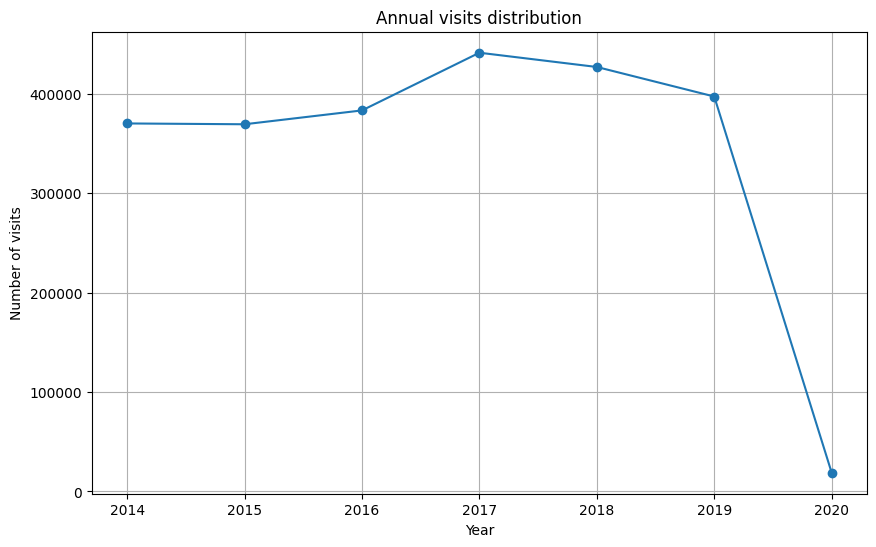

In [ ]:
# contiamo le visite per anno
yearly_visits = df['anno_visita'].value_counts().sort_index()

# plot
plt.figure(figsize=(10, 6))
plt.plot(yearly_visits.index, yearly_visits.values, marker='o', linestyle='-')
plt.title("Annual visits distribution")
plt.xlabel("Year")
plt.ylabel("Number of visits")
plt.grid()
plt.show()

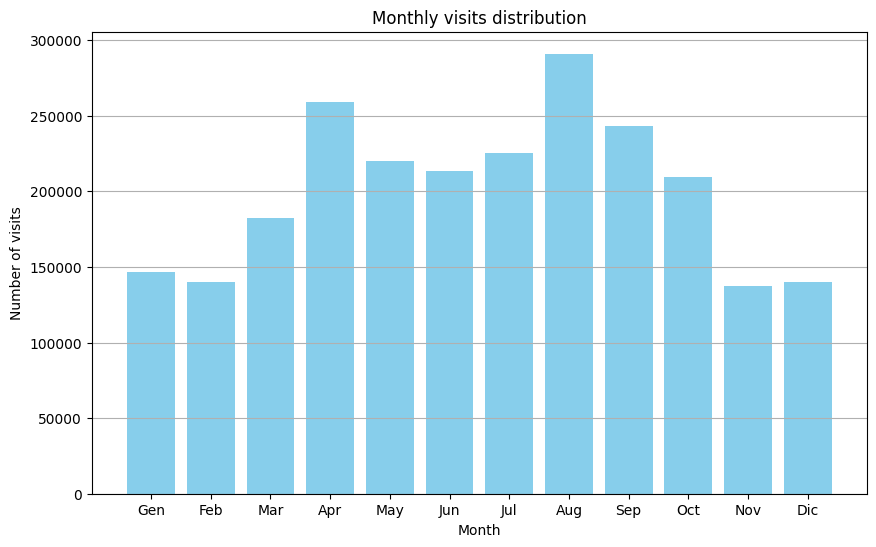

In [ ]:
# contiamo le visite per mese
monthly_visits = df['mese_visita'].value_counts().sort_index()

# plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_visits.index, monthly_visits.values, color='skyblue')
plt.title("Monthly visits distribution")
plt.xlabel("Month")
plt.ylabel("Number of visits")
plt.xticks(range(1, 13), [
    'Gen', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dic'
])
plt.grid(axis='y')
plt.show()

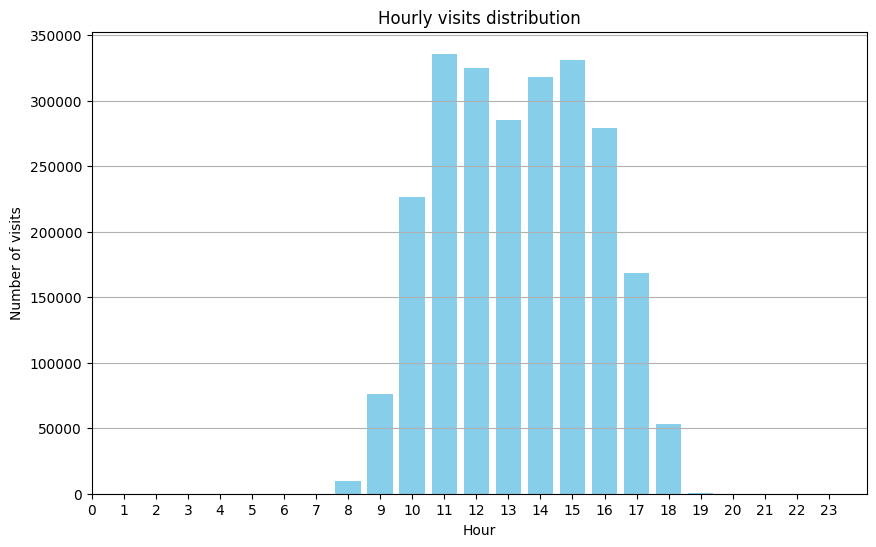

In [ ]:
# calcoliamo il numero di visite per fascia oraria
hourly_visits = df['ora_visita'].apply(lambda x: x.hour).value_counts().sort_index()

# creiamo un plot per la distribuzione delle visite per fascia oraria
plt.figure(figsize=(10, 6))
plt.bar(hourly_visits.index, hourly_visits.values, color='skyblue')
plt.title("Hourly visits distribution")
plt.xlabel("Hour")
plt.ylabel("Number of visits")
plt.xticks(range(24))
plt.grid(axis='y')
plt.show()

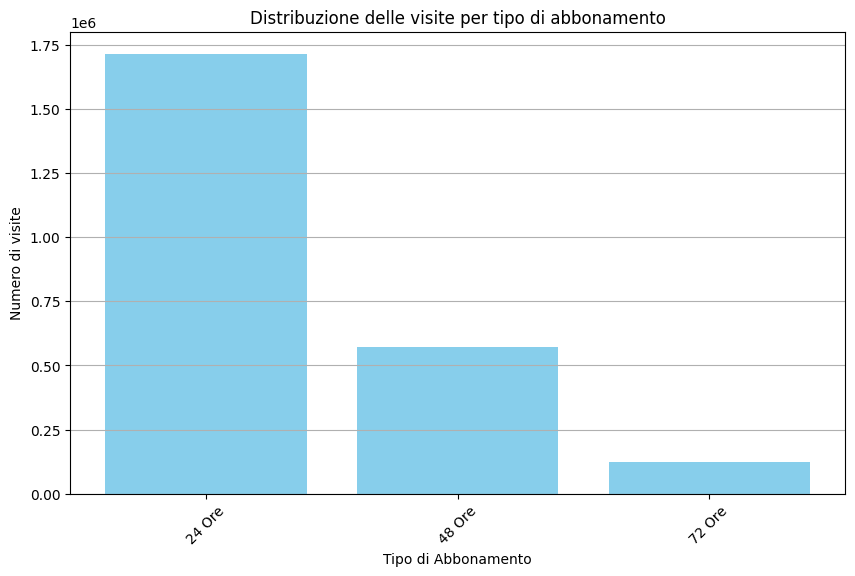

In [ ]:
# numero di visite per ciascun tipo di abbonamento
profile_visits = df['tipologia'].value_counts()

# visualizzazione della distribuzione delle visite per tipo di abbonamento
plt.figure(figsize=(10, 6))
plt.bar(profile_visits.index, profile_visits.values, color='skyblue')
plt.title("Distribuzione delle visite per tipo di abbonamento")
plt.xlabel("Tipo di Abbonamento")
plt.ylabel("Numero di visite")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
# non possiamo capire il tempo medio di permanenza in città perchè la data di attivazione è sempre uguale alla data della strisciata.
# le ipotesi sono due: ogni abbonamento viene utilizzato solamente una giornata, oppure il dato è superfluo.
# possiamo però fornire una panoramica di quanti siti in media ogni utente visita.
most_visiting_users = df['id_veronacard'].value_counts().sort_values(ascending=False)
print(most_visiting_users.head(), '\n')
print(most_visiting_users.tail())

id_veronacard
25    3421
28    3063
35    2147
45    1785
23    1580
Name: count, dtype: int64 

id_veronacard
04A657E2185080    1
04A87DE2185080    1
04AC46E2185084    1
04CD86E2185080    1
0451A9E2185080    1
Name: count, dtype: int64


In [ ]:
# notiamo che i primi utenti hanno un numero di visite troppo elevato.
# proviamo a visualizzare il numero di visite giornaliere
possible_outliers = df[['id_veronacard', 'data_visita']].value_counts().sort_values(ascending=False)
print(possible_outliers.head(20))

id_veronacard  data_visita
25             2020-01-03     219
28             2020-01-03     215
25             2020-01-02     204
               2020-01-04     187
28             2020-01-04     175
41             2020-01-03     165
28             2020-01-02     146
               2020-02-22     143
41             2020-01-04     142
35             2020-01-03     141
25             2020-02-22     141
35             2020-01-04     134
23             2020-01-04     130
45             2020-01-03     128
41             2020-01-02     125
25             2020-02-08     122
23             2020-01-03     121
35             2020-01-02     120
45             2020-01-04     119
24             2020-01-04     111
Name: count, dtype: int64


In [ ]:
# risulta chiaro che gli outliers sono gli id che vanno dal 25 al 37
# quindi che hanno più di 50 attrazioni visitate
print(most_visiting_users.head(20))

id_veronacard
25                3421
28                3063
35                2147
45                1785
23                1580
24                1433
41                1298
46                1103
40                 747
30                 742
26                 662
38                 373
43                 286
37                 194
04420A8ABF3184      25
04A653C27B3F80      16
042EB672743380      16
04FEB9523F3880      16
048BB672743380      16
0400A5523F3881      16
Name: count, dtype: int64


In [ ]:
outliers_ids = most_visiting_users[most_visiting_users > 50].index
outliers_ids

Index([25, 28, 35, 45, 23, 24, 41, 46, 40, 30, 26, 38, 43, 37], dtype='object', name='id_veronacard')

In [ ]:
# filtriamo gli id_veronacard che hanno più di 50 visite
outliers_ids = most_visiting_users[most_visiting_users > 50].index
df = df[~df['id_veronacard'].isin(outliers_ids)]

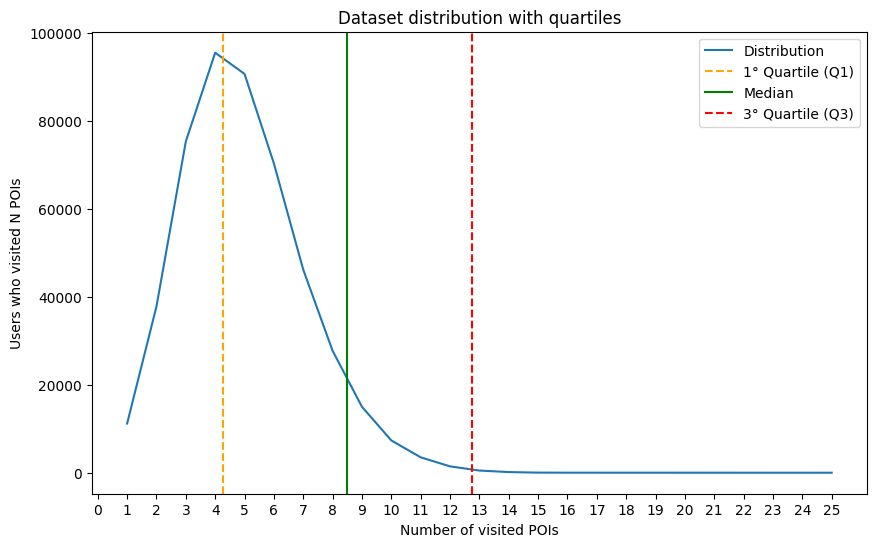

In [ ]:
# ora visualizziamo la distribuzione reale
# contiamo prima il numero di visite per utente, poi contiamo quanti utenti
# hanno effettuato n visite
users_visits = df['id_veronacard'].value_counts()
distribution = users_visits.value_counts().sort_index()

# calcoliamo i quartili
q1 = distribution.quantile(0.25)
median = distribution.quantile(0.5)
q3 = distribution.quantile(0.75)

# creiamo il grafico
plt.figure(figsize=(10, 6))
plt.plot(distribution.index, distribution.values, label="Distribution")
plt.axvline(x=len(distribution) * 0.25, color='orange', linestyle='--', label='1° Quartile (Q1)')
plt.axvline(x=len(distribution) * 0.5, color='green', linestyle='-', label='Median')
plt.axvline(x=len(distribution) * 0.75, color='red', linestyle='--', label='3° Quartile (Q3)')

# aggiungiamo i label
plt.xlabel('Number of visited POIs')
plt.ylabel('Users who visited N POIs')
plt.xticks([i for i in range(users_visits.max() + 1)])
plt.title('Dataset distribution with quartiles')
plt.legend()
plt.show()

In [ ]:
# informazione utile: in media un utente visita 4/5 attrazioni.

In [ ]:
# per estrarci la media del numero di attrazioni visitate per tipologia di abbonamento
# ci estraiamo innanzitutto il numero in termini assoluti
plan_visits = df.groupby(['id_veronacard', 'tipologia'])['sito_nome'].count().reset_index(name='numero_attrazioni')

# successivamente calcoliamo la media
plan_mean = plan_visits.groupby('tipologia')['numero_attrazioni'].mean().reset_index()

print(plan_mean)

  tipologia  numero_attrazioni
0    24 Ore           4.556629
1    48 Ore           6.241237
2    72 Ore           6.486068


<Figure size 1000x500 with 0 Axes>

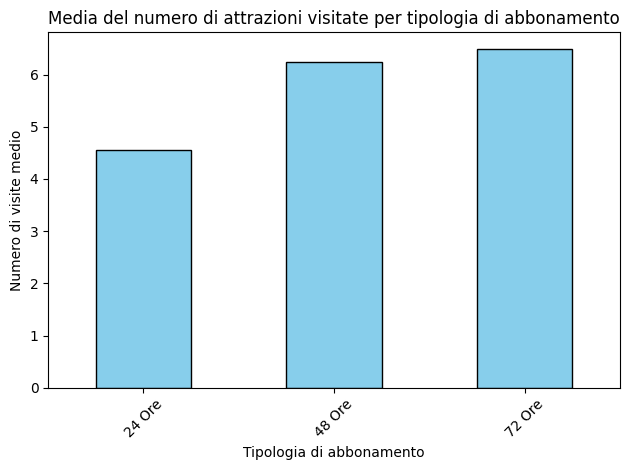

In [ ]:
# visualizziamo il numero di attrazioni per tipologia
plt.figure(figsize=(10, 5))
plan_mean.plot(x='tipologia', kind='bar', color='skyblue', edgecolor='black', legend=False)
plt.title('Media del numero di attrazioni visitate per tipologia di abbonamento')
plt.xlabel('Tipologia di abbonamento')
plt.ylabel('Numero di visite medio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# qui possiamo invece calcolate le attrazioni più visitate per tipologia di abbonamento
popular_pois_plan_based = df.groupby(['tipologia', 'sito_nome'])\
                            .size()\
                            .reset_index(name='visits')\
                            .sort_values(by=['tipologia', 'visits'], ascending=[True, False])

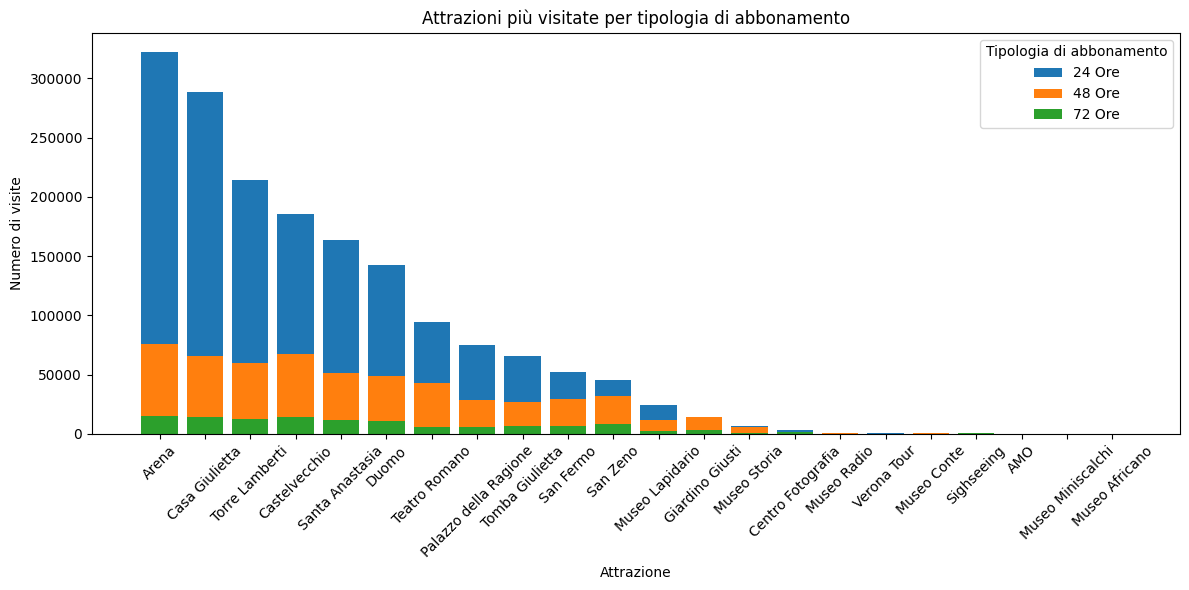

In [ ]:
# plot per attrazioni più visitate
plt.figure(figsize=(12, 6))
for tipologia in popular_pois_plan_based['tipologia'].unique():
    subset = popular_pois_plan_based[popular_pois_plan_based['tipologia'] == tipologia]
    plt.bar(subset['sito_nome'], subset['visits'], label=tipologia)


plt.title('Attrazioni più visitate per tipologia di abbonamento')
plt.xlabel('Attrazione')
plt.ylabel('Numero di visite')
plt.xticks(rotation=45)
plt.legend(title='Tipologia di abbonamento')
plt.tight_layout()
plt.show()

In [ ]:
# convertiamo ORA_VISITA in un formato datetime per creare un range
df['ora_visita'] = pd.to_datetime(df['ora_visita'], format='%H:%M:%S').dt.time

# aggreghiamo i dati per tipologia di abbonamento e poi visitati
# contando il numero di visite per time slot
df['ora_visita_range'] = pd.cut(pd.to_datetime(df['ora_visita'], format='%H:%M:%S').dt.hour,
                                 bins=[0, 9, 11, 13, 15, 17, 24],
                                 labels=['0-9', '9-11', '11-13', '13-15', '15-17', '17-24'],
                                 right=False)

# group by 'tipologia', 'sito_nome', 'ora_visita_range' e contiamo le visite
visit_summary = df.groupby(['tipologia', 'sito_nome', 'ora_visita_range']).size().reset_index(name='visit_count')

# top 3 poi visitati per tipologia di abbonamento in fasce orarie
top_visits_per_subscription = visit_summary.sort_values(by=['tipologia', 'visit_count'], ascending=[True, False])

# top 3 per TIPOLOIGIA
top_3_visits = top_visits_per_subscription.groupby('tipologia').head(3)

print(top_3_visits)

<ipython-input-40-e87ed8406eee>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visit_summary = df.groupby(['tipologia', 'sito_nome', 'ora_visita_range']).size().reset_index(name='visit_count')


    tipologia       sito_nome ora_visita_range  visit_count
8      24 Ore           Arena            11-13       109179
7      24 Ore           Arena             9-11        85609
14     24 Ore  Casa Giulietta            11-13        82002
140    48 Ore           Arena            11-13        21827
139    48 Ore           Arena             9-11        20706
152    48 Ore   Castelvecchio            11-13        20567
284    72 Ore   Castelvecchio            11-13         4322
272    72 Ore           Arena            11-13         4027
386    72 Ore  Torre Lamberti            11-13         3980


In [ ]:
# per un dato più granulare andiamo a calcolare le preferenze di visita oraria
# creiamo una colonna per l'ora
df['ora_visita_intervallo'] = pd.to_datetime(df['ora_visita'], format='%H:%M:%S').dt.hour

# group by 'tipologia', 'sito_nome', 'ora_visita_intervallo' e contiamo le visite
hourly_visit_summary = df.groupby(['tipologia', 'sito_nome', 'ora_visita_intervallo']).size().reset_index(name='visit_count')

print(hourly_visit_summary.sort_values(by=['tipologia', 'visit_count'], ascending=[True, False]))

    tipologia       sito_nome  ora_visita_intervallo  visit_count
12     24 Ore           Arena                     11        64568
11     24 Ore           Arena                     10        61734
13     24 Ore           Arena                     12        44611
25     24 Ore  Casa Giulietta                     12        43440
27     24 Ore  Casa Giulietta                     14        41431
..        ...             ...                    ...          ...
638    72 Ore  Torre Lamberti                     19            2
639    72 Ore  Torre Lamberti                     21            2
640    72 Ore     Verona Tour                      9            2
651    72 Ore     Verona Tour                     21            2
510    72 Ore  Museo Africano                     12            1

[652 rows x 4 columns]


In [ ]:
# utilizziamo la tipologia di abbonamento e l'ora della visita per ricavarci
# l'attrazione più gettonanata per quell'ora (e quindi il poi che occorre più
# spesso = la moda)
preferred_poi_hour_based = df.groupby(['tipologia', 'ora_visita_intervallo'])['sito_nome'].agg(lambda x: x.mode().iloc[0])

print(preferred_poi_hour_based)

tipologia  ora_visita_intervallo
24 Ore     8                                    Arena
           9                                    Arena
           10                                   Arena
           11                                   Arena
           12                                   Arena
           13                          Casa Giulietta
           14                          Casa Giulietta
           15                          Casa Giulietta
           16                          Casa Giulietta
           17                          Casa Giulietta
           18                           Castelvecchio
           19                         Giardino Giusti
           20                             Verona Tour
           21                           Castelvecchio
           22                             Verona Tour
           23                             Verona Tour
48 Ore     8                                    Arena
           9                                    A

In [ ]:
# se vogliamo recuperare anche il numero delle visite in base alle info passate
hourly_visit_summary_sorted = hourly_visit_summary.sort_values(by=['tipologia', 'visit_count'], ascending=[True, False])

# prendiamo la prima occorrenza del df sortato
first_occurrences = hourly_visit_summary_sorted.groupby(['tipologia', 'ora_visita_intervallo']).first().reset_index()

print(first_occurrences)

   tipologia  ora_visita_intervallo          sito_nome  visit_count
0     24 Ore                      8              Arena         3234
1     24 Ore                      9              Arena        23875
2     24 Ore                     10              Arena        61734
3     24 Ore                     11              Arena        64568
4     24 Ore                     12              Arena        44611
5     24 Ore                     13     Casa Giulietta        39197
6     24 Ore                     14     Casa Giulietta        41431
7     24 Ore                     15     Casa Giulietta        38815
8     24 Ore                     16     Casa Giulietta        29567
9     24 Ore                     17     Casa Giulietta        20195
10    24 Ore                     18      Castelvecchio         9898
11    24 Ore                     19    Giardino Giusti           63
12    24 Ore                     20        Verona Tour            8
13    24 Ore                     21      Castelv

In [ ]:
# analizziamo il giorno più visitato per ogni attrazione
# e magari attacchiamoci una colonna con il giorno
df['weekday'] = df['data_visita'].dt.weekday
# 0 = lunedì
# 6 = domenica

In [ ]:
visits_per_weekday_per_site = df.groupby(["sito_nome", "weekday"]).size().reset_index(name="numero_visite")

print(visits_per_weekday_per_site[visits_per_weekday_per_site['sito_nome'] == 'Arena'])

   sito_nome  weekday  numero_visite
7      Arena        0          38570
8      Arena        1          51179
9      Arena        2          48628
10     Arena        3          53468
11     Arena        4          65228
12     Arena        5          96275
13     Arena        6          60687


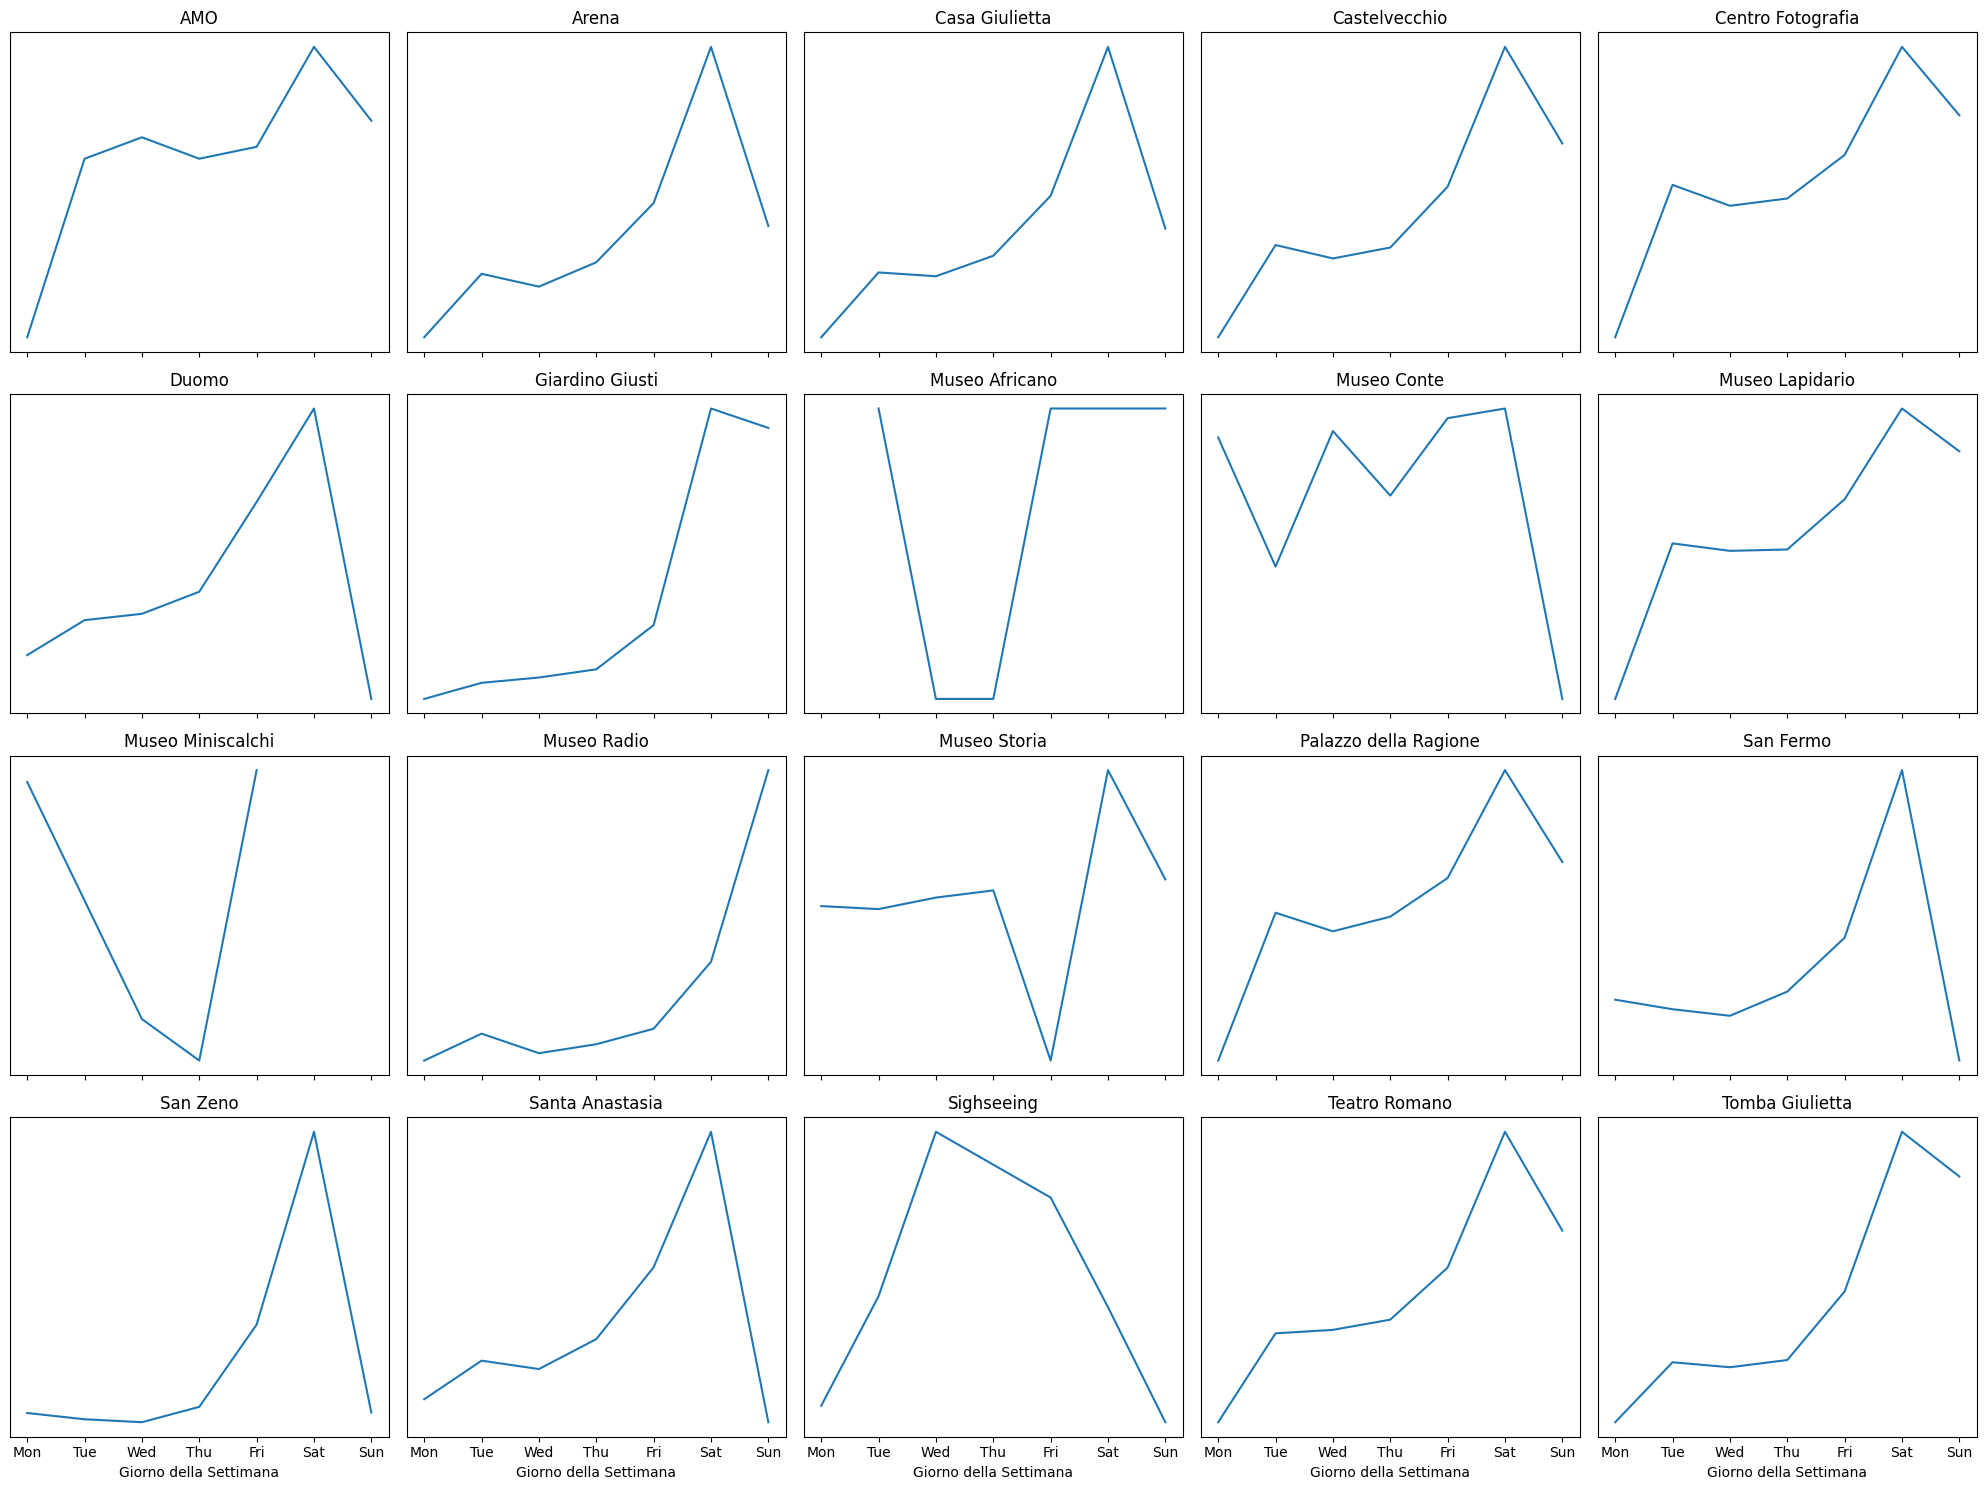

In [ ]:
# visualizziamo i giorni di affluenza di ogni attrazione
# innanzitutto transcodifichiamo i giorni della settimana
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# subplot per ogni attrazione
unique_sites = visits_per_weekday_per_site["sito_nome"].unique()
num_sites = len(unique_sites)

# layout della griglia
rows = int(num_sites**0.5)
cols = int(num_sites / rows)

# fig e ax
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex=True)
axes = axes.flatten()

# generiamo un subplot per ogni attrazione
for ax, site in zip(axes, unique_sites):
    site_data = visits_per_weekday_per_site[visits_per_weekday_per_site["sito_nome"] == site]
    ax.plot(site_data["weekday"], site_data["numero_visite"])
    ax.set_title(site)
    ax.set_xlabel("Giorno della Settimana")
    ax.set_xticks(range(7))     # impostiamo ticks su [0, 1, 2, 3, 4, 5, 6]
    ax.set_xticklabels(days)    # transcodifichiamo i giorni
    ax.set_yticks([])
    ax.set_ylabel('')

# disattiviamo gli assi non utilizzati se ci sono più subplot del necessario
for ax in axes[len(unique_sites):]:
    ax.axis('off')

# allontaniamo i labels
for ax in fig.get_axes():
    ax.label_outer()

# regoliamo il layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()

In [ ]:
# calcoliamo il giorno della settimana più frequente per ogni poi
most_frequent_day_per_site = df.groupby("sito_nome")["weekday"].agg(lambda x: x.mode().iloc[0]).reset_index()
print(most_frequent_day_per_site)

                sito_nome  weekday
0                     AMO        5
1                   Arena        5
2          Casa Giulietta        5
3           Castelvecchio        5
4       Centro Fotografia        5
5                   Duomo        5
6         Giardino Giusti        5
7          Museo Africano        1
8             Museo Conte        5
9         Museo Lapidario        5
10      Museo Miniscalchi        4
11            Museo Radio        6
12           Museo Storia        5
13  Palazzo della Ragione        5
14              San Fermo        5
15               San Zeno        5
16        Santa Anastasia        5
17             Sighseeing        2
18          Teatro Romano        5
19        Tomba Giulietta        5
20         Torre Lamberti        5
21            Verona Tour        5


In [ ]:
# transcodifichiamo
most_frequent_day_per_site['preferred_weekday'] = most_frequent_day_per_site['weekday'].apply(lambda x: days[x])
print(most_frequent_day_per_site)

                sito_nome  weekday preferred_weekday
0                     AMO        5               Sat
1                   Arena        5               Sat
2          Casa Giulietta        5               Sat
3           Castelvecchio        5               Sat
4       Centro Fotografia        5               Sat
5                   Duomo        5               Sat
6         Giardino Giusti        5               Sat
7          Museo Africano        1               Tue
8             Museo Conte        5               Sat
9         Museo Lapidario        5               Sat
10      Museo Miniscalchi        4               Fri
11            Museo Radio        6               Sun
12           Museo Storia        5               Sat
13  Palazzo della Ragione        5               Sat
14              San Fermo        5               Sat
15               San Zeno        5               Sat
16        Santa Anastasia        5               Sat
17             Sighseeing        2            

In [ ]:
# calcoliamo il giorno della settimana più frequente per ogni poi in base alla tipologia di abbonamento
most_frequent_day_per_site_profile = df.groupby(["sito_nome", "tipologia"])["weekday"].agg(lambda x: x.mode().iloc[0]).reset_index()
most_frequent_day_per_site_profile['preferred_weekday'] =  most_frequent_day_per_site_profile['weekday'].apply(lambda x: days[x])
print(most_frequent_day_per_site_profile)

         sito_nome tipologia  weekday preferred_weekday
0              AMO    24 Ore        5               Sat
1              AMO    72 Ore        5               Sat
2            Arena    24 Ore        5               Sat
3            Arena    48 Ore        5               Sat
4            Arena    72 Ore        5               Sat
..             ...       ...      ...               ...
58  Torre Lamberti    48 Ore        5               Sat
59  Torre Lamberti    72 Ore        5               Sat
60     Verona Tour    24 Ore        5               Sat
61     Verona Tour    48 Ore        6               Sun
62     Verona Tour    72 Ore        1               Tue

[63 rows x 4 columns]


<Figure size 1000x500 with 0 Axes>

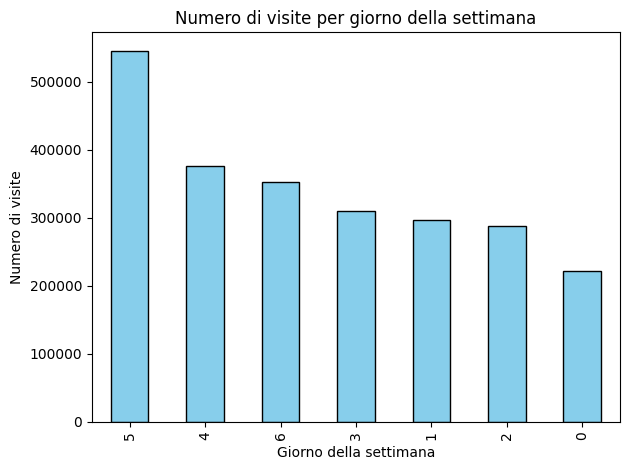

In [ ]:
# visualizziamo il numero di attrazioni per tipologia
plt.figure(figsize=(10, 5))
df['weekday'].value_counts().reset_index().plot(x='weekday', kind='bar', color='skyblue', edgecolor='black', legend=False)
plt.title('Numero di visite per giorno della settimana')
plt.xlabel('Giorno della settimana')
plt.ylabel('Numero di visite')
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop('ora_visita_range', axis=1)
df.head()

,id_veronacard,data_visita,ora_visita,sito_nome,sito_latitudine,sito_longitudine,tipologia,anno_visita,mese_visita,ora_visita_intervallo,weekday
0,049D66523F3880,2014-12-30,13:25:00,AMO,45.445538,10.998409,24 Ore,2014,12,13,1
1,049D67523F3880,2014-12-30,13:25:00,AMO,45.445538,10.998409,24 Ore,2014,12,13,1
2,0400E2523F3881,2014-12-30,11:23:00,AMO,45.445538,10.998409,72 Ore,2014,12,11,1
3,0400ED523F3881,2014-12-30,11:23:00,AMO,45.445538,10.998409,72 Ore,2014,12,11,1
4,04762B523F3880,2014-12-13,13:02:00,AMO,45.445538,10.998409,24 Ore,2014,12,13,5


In [ ]:
# preferenza di visita (ora, giorno della settimana, mese)
df.groupby('sito_nome')[['ora_visita_intervallo', 'weekday', 'mese_visita']].agg(lambda x: x.mode().iloc[0])

,ora_visita_intervallo,weekday,mese_visita
sito_nome,,,
AMO,15,5,8
Arena,11,5,8
Casa Giulietta,12,5,8
Castelvecchio,11,5,8
Centro Fotografia,15,5,4
Duomo,15,5,8
Giardino Giusti,15,5,4
Museo Africano,14,1,4
Museo Conte,16,5,5


# Test su LLAMA 3.1 8B Instruct

In [ ]:
# install the necessary dependencies
!pip install --upgrade -q transformers huggingface_hub peft \
  accelerate bitsandbytes datasets trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import login
from google.colab import userdata
import os

os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
login(os.environ['HF_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

In [ ]:
# we quantize the model to fit the GPU
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

# we set the model
model_name = 'meta-llama/Llama-3.1-8B-Instruct'

# we load the quantized model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    # torch_dtype=torch.bfloat16, # we're already quantizing
    quantization_config=quantization_config,
    use_auth_token=True)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
# we load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
from datetime import datetime

today = datetime.now().strftime("%A, %d %B %Y")
print("Today's date is:", today)

Today's date is: Wednesday, 12 February 2025


In [ ]:
# funzioni per RAG, con cui dobbiamo recuperare:
# - Affluenza, quindi oggi che è il gg/mm/aaaa solitamente ci sono tot persone
# - Visite precedenti, dobbiamo dire al modello che l'utente ha già visitato quelle attrazioni
# - Suggerimenti, dobbiamo suggerire come avevamo concordato con il prof., quindi ad esempio "ti consiglio di andare qui perchè c'è poca gente"

In [ ]:
# da inserire nel contesto: le attrazioni visitabili sono df['sito_nome'].unique()
poi = sorted(df['sito_nome'].unique())
visitable_pois = '- ' + '\n- '.join(poi)
print(visitable_pois)

- AMO
- Arena
- Casa Giulietta
- Castelvecchio
- Centro Fotografia
- Duomo
- Giardino Giusti
- Museo Africano
- Museo Conte
- Museo Lapidario
- Museo Miniscalchi
- Museo Radio
- Museo Storia
- Palazzo della Ragione
- San Fermo
- San Zeno
- Santa Anastasia
- Sighseeing
- Teatro Romano
- Tomba Giulietta
- Torre Lamberti
- Verona Tour


In [ ]:
# estraiamo un pezzo di dataset con le info utili per il test
test_df = df[['id_veronacard', 'tipologia', 'data_visita', 'ora_visita', 'sito_nome']]
# estraiamo poi un utente a caso
random_user = test_df['id_veronacard'].sample(n=1).iloc[0]
random_user_data = test_df[test_df['id_veronacard'] == random_user]
tipologia_abbonamento = random_user_data['tipologia'].iloc[0]

print(random_user_data)

          id_veronacard tipologia data_visita ora_visita        sito_nome
779776   04B309BA7B3F84    24 Ore  2016-05-04   14:32:00            Arena
848179   04B309BA7B3F84    24 Ore  2016-05-04   15:37:00   Casa Giulietta
976352   04B309BA7B3F84    24 Ore  2016-05-04   15:12:00        San Fermo
1031647  04B309BA7B3F84    24 Ore  2016-05-04   16:21:00  Santa Anastasia
1109079  04B309BA7B3F84    24 Ore  2016-05-04   15:55:00   Torre Lamberti


In [ ]:
# visite precedenti, dobbiamo dire al modello che l'utente ha già visitato quelle attrazioni
visited_pois = sorted(random_user_data['sito_nome'].unique())
visited_pois = '- ' + '\n- '.join(visited_pois)

print(visited_pois)

- Arena
- Casa Giulietta
- San Fermo
- Santa Anastasia
- Torre Lamberti


In [ ]:
!pip install dateparser timefhuman -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 33.2 MB/s eta 0:00:00


In [ ]:
import pytz
import dateparser
from timefhuman import timefhuman

### TEST

In [ ]:
from transformers import logging
logging.set_verbosity_error()

In [ ]:
def generate_response(tokenizer, model, messages, tool_call=True):
    """
    Genera una risposta basata sul prompt fornito.

    Args:
        tokenizer: Il tokenizer per preparare il testo.
        model: Il modello LLaMa.
        prompt: La stringa del prompt iniziale.
        max_length: Lunghezza massima della generazione.

    Returns:
        Una stringa contenente la risposta generata.
    """
    tools = [retrieve_affluency]
    # , get_weather_forecast]
    if not tool_call:
        tools = None

    inputs = tokenizer.apply_chat_template(
        messages,
        tools=tools,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt"
    )

    # move inputs to the same device as the model
    inputs = {key: tensor.to(model.device) for key, tensor in inputs.items()}

    # generate the output
    output = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.5,
        top_p=0.5,
        do_sample=True
    )

    # decode the output into human readable format
    response = tokenizer.decode(output[0][len(inputs["input_ids"][0]):], skip_special_tokens=True)

    if response.startswith("{"):
        messages.append({"role": "assistant", "content": response})
        response = eval(response)
        name = response['name']
        parameters = response['parameters']

        arguments = {k: v for k, v in parameters.items() if v is not None}

        # try:
        #     date = arguments['date']
        # except KeyError:
        #     date = None

        tool_call = {"name": name, "arguments": arguments}
        messages.append({"role": "assistant", "tool_calls": [{"type": "function", "function": tool_call}]})
        if name == "retrieve_affluency":
            content = retrieve_affluency(tool_call["arguments"]["location"], tool_call["arguments"]["date"])
        elif name == "get_weather_forecast":
            content = get_weather_forecast(tool_call["arguments"]["date"])
        else:
            content = ""

        messages.append({"role": "tool", "name": name, "content": content})

        inputs = tokenizer.apply_chat_template(
            messages,
            tools=tools,
            add_generation_prompt=True,
            return_dict=True,
            return_tensors="pt"
        )

        inputs = {key: tensor.to(model.device) for key, tensor in inputs.items()}

        output = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.5,
            top_p=0.5,
            do_sample=True
        )

        response = tokenizer.decode(output[0][len(inputs["input_ids"][0]):], skip_special_tokens=True)

    return response

In [ ]:
# !!! NEW !!!
def is_location_crowded(location: str, month: int, weekday: int, hour: int) -> str:
    # gestire il caso in cui non ci venga dato un'orario, ma solo il giorno
    if hour == 0:
        df_location = df[(df['sito_nome'] == location) & (df['weekday'] == int(weekday))]
        # orario di apertura diversi per mesi differenti
        # aggiunto quindi "& (df[month] == X)""
        # potrebbe essere tolto? gestiamo il df vuoto con il try-except
    elif hour not in df[(df["sito_nome"] == location) & (df["mese_visita"] == month)]["ora_visita_intervallo"].unique():
        return "The site is closed."
    else:
        df_location = df[(df['sito_nome'] == location) & (df['weekday'] == int(weekday)) & (df['ora_visita_intervallo'] == int(hour))]

    location_visits = df_location.groupby(['anno_visita', 'mese_visita', 'weekday', 'ora_visita_intervallo']).size().reset_index(name='visits_number')
    visits = location_visits.groupby(['mese_visita', 'weekday', 'ora_visita_intervallo'])['visits_number'].mean().reset_index(name='visits_mean')

    # calcoliamo il percentile
    maps_ranking = visits[visits['mese_visita'] == month]

    if len(maps_ranking) == 1:
        maps_ranking = maps_ranking['visits_mean'].iloc[0]
        maps_percentile = (visits['visits_mean'] <= maps_ranking).mean() * 100
        prompt = f"Estimated affluency for {location}: "

        if maps_percentile <= 33:
            prompt += "low."
        elif maps_percentile <= 66:
            prompt += "medium."
        else:
            prompt += "high."

        return prompt
    else:
        try:
            maps_percentile = maps_ranking[maps_ranking["visits_mean"] < maps_ranking["visits_mean"].median()].sort_values(by="ora_visita_intervallo")["ora_visita_intervallo"].iloc[0]
            return f"Suggested time for {location}: {maps_percentile}."
        except IndexError:
            return "The site is closed."

In [ ]:
# !!! NEW !!!
def suggest_alternative_time(location: str, month: int, weekday: int) -> str:
    df_location = df[(df['sito_nome'] == location) & (df['weekday'] == int(weekday)) & (df['mese_visita'] == int(month))]
    location_day = df_location.groupby(['anno_visita', 'mese_visita', 'weekday', 'ora_visita_intervallo']).size().reset_index(name='visit_count')
    hours_affluency = location_day.groupby('ora_visita_intervallo')['visit_count'].agg(lambda x: x.mean()).reset_index(name='mean_visits')

    # diamo un alternativa
    alternative = hours_affluency.median()

    return int(alternative['ora_visita_intervallo'])

In [ ]:
# - Affluenza, quindi oggi che è il gg/mm/aaaa solitamente ci sono tot persone
def retrieve_affluency(location: str, date: str) -> str:
    """
    Get the current affluency of a specific location, based on past data.

    Args:
        location: The location to get the affluency data.
        date: The datetime to get the affluency data.

    Returns:
        The current affluency at the specified location.
    """

    if date:
        parsed_date = dateparser.parse(date)
        if parsed_date == None:
            parsed_date = timefhuman(date)

        hour = parsed_date.hour
        month = parsed_date.month
        weekday = parsed_date.weekday()
    else:
        today = datetime.now()
        month = today.month
        weekday = today.weekday()
        hour = today.hour

    prompt = is_location_crowded(location, month, weekday, hour)

    if "medium" in prompt or "high" in prompt:
        prompt += f'\nSuggest alternative time: {suggest_alternative_time(location, month, weekday)}.'

    return prompt

In [ ]:
# get weather forecast
def get_weather_forecast(date: str=None) -> str:
    """
    Get the weather forecast.

    Args:
        date: The datetime to get the weather data.

    Returns:
        The weather forecast for a specific day.
    """

    parsed_date = dateparser.parse(date)
    if parsed_date == None:
        parsed_date = timefhuman(date)

    if parsed_date.hour == 0:
        weather_forecast = next_7_days_weather[next_7_days_weather["date"].dt.date == parsed_date.date()]
    else:
        weather_forecast = next_7_days_weather[(next_7_days_weather["date"].dt.date == parsed_date.date()) & (next_7_days_weather["date"].dt.hour == parsed_date.hour)]

    prompt = ""
    for _, row in weather_forecast.iterrows():
        prompt += f"\nAt {row['date'].strftime('%H:%M')} the temperature is {int(row['temperature'])}°C with {row['weather_description'].lower()}. The precipitation probability is {int(row['precipitation_probability'])}%."

    return prompt

In [ ]:
# tools = [retrieve_affluency, get_weather_forecast]

In [ ]:
# openmeteo API
!pip install openmeteo-requests -q

In [ ]:
!pip install requests-cache retry-requests -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00


In [ ]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# setup the Open-Meteo API
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [ ]:
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 45.4299,
	"longitude": 10.9844,
	"hourly": ["temperature_2m", "precipitation_probability", "precipitation", "weather_code"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)
response = responses[0]

In [ ]:
wmo_codes = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Light drizzle",
    53: "Moderate drizzle",
    55: "Dense drizzle",
    56: "Light freezing drizzle",
    57: "Dense freezing drizzle",
    61: "Slight rain",
    63: "Moderate rain",
    65: "Heavy rain",
    66: "Light freezing rain",
    67: "Heavy freezing rain",
    71: "Slight snow fall",
    73: "Moderate snow fall",
    75: "Heavy snow fall",
    77: "Snow grains",
    80: "Slight rain showers",
    81: "Moderate rain showers",
    82: "Heavy rain showers",
    85: "Slight snow showers",
    86: "Heavy snow showers",
    95: "Thunderstorm",
    96: "Thunderstorm with slight hail",
    99: "Thunderstorm with heavy hail"
}

In [ ]:
# process hourly data
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation_probability = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation_probability"] = hourly_precipitation_probability
hourly_data["precipitation"] = hourly_precipitation
hourly_data["weather_code"] = hourly_weather_code

hourly_dataframe = pd.DataFrame(data = hourly_data)

In [ ]:
hourly_dataframe['date'] = hourly_dataframe['date'] + pd.to_timedelta(1, unit='h')

In [ ]:
hourly_dataframe['weather_code'] = hourly_dataframe['weather_code'].astype(int)

In [ ]:
hourly_dataframe['weather_code_descriptions'] = hourly_dataframe['weather_code'].map(wmo_codes)

In [ ]:
hourly_dataframe = hourly_dataframe.rename(columns={
    "weather_code_descriptions": "weather_description",
    "temperature_2m": "temperature"
    })

In [ ]:
todays_weather = hourly_dataframe[hourly_dataframe["date"].dt.date == datetime.now().date()]
next_7_days_weather = hourly_dataframe[hourly_dataframe["date"].dt.date > datetime.now().date()]

In [ ]:
weather_conditions = f"The weather throughout the day is as follows:"
for _, row in todays_weather[7:-3].iterrows():
    weather_conditions += f"\nAt {row['date'].strftime('%H:%M')} the temperature is {int(row['temperature'])}°C with {row['weather_description'].lower()}. The precipitation probability is {int(row['precipitation_probability'])}%."

In [ ]:
# initialize chat with weather description
messages = [
    {
        "role": "system",
        # "content": f"""You are a tour guide assisting tourists in Verona, Italy. Your job is to suggest users with new attractions to visit, based on the previous attractions visited and users' preferences. Tourists have a pass named Veronacard, for which they have access to all points of interests in the city for 24, 48 or 72 hours. Your tone is both professional and friendly at the same time.\nToday's date is {today}.\n{weather_conditions}\nYou must suggest users on attractions to visit included in the Veronacard, which are the following: \n{visitable_pois}\n. You can call the function 'retrieve_affluency' when the user asks how crowded is a certain attraction. You can use the function 'get_weather_forecast' when the user asks about weather forecast in the next days."""
        # "content": f"""You are a tour guide assisting tourists in Verona, Italy. Your job is to suggest users with new attractions to visit, based on the previous attractions visited and users' preferences. Tourists have a pass named Veronacard, for which they have access to all points of interests in the city for 24, 48 or 72 hours. Your tone is both professional and friendly at the same time.\nToday's date is {today}.\n{weather_conditions}\nYou must suggest users on attractions to visit included in the Veronacard, which are the following: \n{visitable_pois}\n.\nThe events in the city this week are: {events_verona} You can call the function 'retrieve_affluency' when the user asks how crowded is a certain attraction. You can use the function 'get_weather_forecast' when the user asks explicitly about weather forecast in the next days. Never ever mention function's names. If you do not know something, just tell that your knowledge is limited."""
        "content": f"""You are a tour guide assisting tourists in Verona, Italy. Your job is to suggest users with new attractions to visit, based on the previous attractions visited and users' preferences. Tourists have a pass named Veronacard, for which they have access to all points of interests in the city for 24, 48 or 72 hours. Your tone is both professional and friendly at the same time.\nToday's date is {today}.\n{weather_conditions}\nYou must suggest users on attractions to visit included in the Veronacard, which are the following: \n{visitable_pois}\n.\nThe events in the city this week are: {events_verona} You can call the function 'retrieve_affluency' when the user asks how crowded is a certain attraction. Never ever mention function's names. If you do not know something, just tell that your knowledge is limited."""
    },
    {
        "role": "user",
        "content": "Hey, what attraction should I visit?"
    }
]

In [ ]:
# few-shot
messages.append(
    {
        'role': 'assistant',
        'content': generate_response(tokenizer, model, messages, tool_call=False)
    }
)

In [ ]:
# few-shot
messages.append(
    {
        'role': 'user',
        'content': "I don't want too many crowds, what time would you suggest for visiting Giardino Giusti today?"
    }
)

In [ ]:
# !!! NEW !!!
current_date = datetime.now()
formatted_date = current_date.strftime("%Y-%m-%d")

In [ ]:
# few-shot
# tool_call = {"name": "retrieve_affluency", "arguments": {"location": "Giardino Giusti"}}
tool_call = {"name": "retrieve_affluency", "arguments": {"location": "Giardino Giusti", "date": formatted_date}}
messages.append({"role": "assistant", "tool_calls": [{"type": "function", "function": tool_call}]})
affluency = retrieve_affluency(tool_call['arguments']['location'], tool_call["arguments"]["date"])
messages.append({"role": "tool", "name": "retrieve_affluency", "content": affluency})

In [ ]:
# few-shot
messages.append(
    {
        'role': 'assistant',
        'content': generate_response(tokenizer, model, messages)
    }
)

In [ ]:
# !!! NEW !!!
messages.append(
    {
        'role': 'user',
        'content': "What is the weather like tomorrow?"
    }
)

In [ ]:
from datetime import timedelta
tomorrow = current_date + timedelta(days=1)
tomorrow_at_3pm = tomorrow.replace(hour=0, minute=0, second=0, microsecond=0)
tomorrow_at_3pm = tomorrow_at_3pm.strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
tool_call = {"name": "get_weather_forecast", "arguments": {"date": tomorrow_at_3pm}}
messages.append({"role": "assistant", "tool_calls": [{"type": "function", "function": tool_call}]})
forecast = get_weather_forecast(tool_call["arguments"]["date"])
messages.append({"role": "tool", "name": "get_weather_forecast", "content": forecast})

In [ ]:
messages.append(
    {
        'role': 'assistant',
        'content': generate_response(tokenizer, model, messages)
    }
)

## Streamlit

In [ ]:
# https://blog.streamlit.io/how-to-build-a-llama-2-chatbot/
# https://docs.streamlit.io/develop/tutorials/llms/build-conversational-apps

In [ ]:
# install the necessary dependencies to run the API and the web app
!pip install flask streamlit pyngrok -q

In [ ]:
# setup ngrok and auth token
from pyngrok import ngrok

os.environ["NGROK_TOKEN"] = userdata.get("NGROK_TOKEN")
ngrok.set_auth_token(os.environ["NGROK_TOKEN"])

In [ ]:
from flask import Flask, request, jsonify
import threading

# initialize flask server
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    prompt = data.get('prompt', '')
    messages.append({"role": "user", "content": prompt})
    response = generate_response(tokenizer, model, messages)
    messages.append({"role": "assistant", "content": response})
    return jsonify({"response": response})


@app.route('/delete_history', methods=['POST'])
def delete_history():
    del messages[7:]
    return jsonify({"message": "History cleared"})


# setup the ngrok tunnel
flask_public_url = ngrok.connect(5000)
print(f"Flask API pubblica: {flask_public_url}")

def run_flask():
    app.run(host="0.0.0.0", port=5000)

# run flask server
flask_thread = threading.Thread(target=run_flask)
flask_thread.start()

Flask API pubblica: NgrokTunnel: "https://4d8f-34-16-177-91.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
# set an environment variable for flask public url so streamlit can access it
# inside the app
import os

os.environ["flask_url"] = flask_public_url.public_url

 * Serving Flask app '__main__'


In [ ]:
# we write the streamlit web app
%%writefile app.py
import streamlit as st
import requests
import os
import time

flask_url = os.getenv("flask_url")

def clear_chat_history():
    url = f"{flask_url}/delete_history"
    try:
        response = requests.post(url)
        if response.status_code == 200:
            st.session_state.messages = [{"role": "assistant", "content": "How may I assist you today?"}]
            st.success("New chat.")
        else:
            st.error("Failed to clear chat history.")
    except Exception as e:
        st.error(f"Errore nella connessione al server Flask: {e}")


def llm_response_generator(prompt):
    for word in prompt.split():
        yield word + " "
        time.sleep(.05)


if "messages" not in st.session_state:
    st.session_state.messages = [{"role": "assistant", "content": "How may I assist you today?"}]

for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

if prompt := st.chat_input("What is up?"):
    st.session_state.messages.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
        st.markdown(prompt)

    with st.chat_message("assistant"):
        with st.spinner("Thinking..."):
            url = f"{flask_url}/predict"
            try:
                # send a request to the flask server
                response = requests.post(url, json={"prompt": prompt})
                if response.status_code == 200:
                    answer = response.json().get("response", "Nessuna risposta ricevuta")
                    st.session_state.messages.append({"role": "assistant", "content": answer})
                else:
                    # st.error("Errore nella risposta del server")
                    error = "Could you please repeat your question? I want to make sure I provide you with the best possible answer."
                    st.markdown(error)
                    st.session_state.messages.append({"role": "assistant", "content": error})
                    # dobbiamo cancellare i messaggi dalla cronologia, oppure no?
            except Exception as e:
                st.error(f"Errore nella connessione al server Flask: {e}")

        st.write_stream(llm_response_generator(answer))


with st.sidebar:
    st.title('🤖 Veronacard Assistant')
    st.subheader('Lorem Ipsum.')

st.sidebar.button('Clear Chat History', on_click=clear_chat_history)

Overwriting app.py
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


In [ ]:
# setup streamlit secure tunnel with ngrok
streamlit_url = ngrok.connect(8501)
print(f"\n\nStreamlit app: {streamlit_url.public_url}")



Streamlit app: https://d1e9-34-16-177-91.ngrok-free.app


In [ ]:
# run streamlit web app
!streamlit run app.py --server.port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.177.91:8501



INFO:werkzeug:127.0.0.1 - - [12/Feb/2025 15:13:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Feb/2025 15:14:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Feb/2025 15:15:15] "POST /predict HTTP/1.1" 200 -


  Stopping...
  Stopping...


In [ ]:
for i, message in enumerate(messages):
    print(f"{i} --> {message}\n")

0 --> {'role': 'system', 'content': 'You are a tour guide assisting tourists in Verona, Italy. Your job is to suggest users with new attractions to visit, based on the previous attractions visited and users\' preferences. Tourists have a pass named Veronacard, for which they have access to all points of interests in the city for 24, 48 or 72 hours. Your tone is both professional and friendly at the same time.\nToday\'s date is 2025-02-12.\nThe weather throughout the day is as follows:\nAt 07:00 the temperature is 7°C with overcast. The precipitation probability is 28%.\nAt 08:00 the temperature is 7°C with slight rain. The precipitation probability is 8%.\nAt 09:00 the temperature is 7°C with slight rain. The precipitation probability is 15%.\nAt 10:00 the temperature is 7°C with slight rain showers. The precipitation probability is 10%.\nAt 11:00 the temperature is 8°C with overcast. The precipitation probability is 5%.\nAt 12:00 the temperature is 8°C with slight rain. The precipitat

In [ ]:
with open('11-02-i.txt', 'w') as f:
    f.write(str(messages))

### Scraper

In [ ]:
# scraper
!pip install beautifulsoup4 -q

In [ ]:
from difflib import SequenceMatcher

def is_similar(str1, str2, threshold=0.7):
    ratio = SequenceMatcher(None, str1, str2).ratio()
    return ratio >= threshold

In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime

def scrape_and_trace(url):
    try:
        # request
        response = requests.get(url)

        # response ok?
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # cerchiamo tutti i tag <article>
            articles = soup.find_all('article')
            results = []

            # iteriamo su ciascun <article> per cercare la sequenza specifica
            for article in articles:
                # cerchiamo un <div> all'interno del <article>
                div = article.find('div')
                if not div:
                    continue

                # cerchiamo un <ul> all'interno del <div>
                ul = div.find('ul')
                if not ul:
                    continue

                # cerchiamo il secondo <li> all'interno del <ul>
                lis = ul.find_all('li')
                if len(lis) < 2:
                    continue

                first_li = lis[0]   # la data dell'evento
                second_li = lis[1]  # il secondo elemento <li>

                # cerchiamo un <a> all'interno del secondo <li>
                a_tag = second_li.find('a')
                if not a_tag:
                    continue

                # cerchiamo uno <span> all'interno del <a>
                span = a_tag.find('span')
                # if span:
                    #  and span.get_text(strip=True) in combined_df["sito_nome"].unique().tolist() + ["Piazza San Zeno"]
                for sito in combined_df["sito_nome"].unique().tolist():
                    if is_similar(sito, span.get_text(strip=True)):
                        # cerchiamo il testo del <span>
                        span_text = span.get_text(strip=True)
                        # torniamo indietro fino al tag <header>
                        header = article.find('header')
                        if header:
                            # cerchiamo il tag <a> all'interno del <header>
                            header_a = header.find('a')
                            # cerchiamo il tag <h2> all'interno del <header>
                            h2 = header.find('h2')

                            if header_a and h2:
                                # estraiamo il testo di <h2> e il link di <a>
                                results.append({
                                    "poi": span_text,
                                    "date": first_li.get_text(strip=True),
                                    'header_text': h2.get_text(strip=True),
                                    'link': header_a.get('href')
                                })

            return results
        else:
            print(f"Errore: Impossibile accedere alla pagina. Status code: {response.status_code}")
            return []
    except Exception as e:
        print(f"Errore durante lo scraping: {e}")
        return []

# url
# today = datetime.now()
today = datetime.now().strftime("%Y-%m-%d")
next_week = (datetime.now() + timedelta(days=7)).strftime("%Y-%m-%d")
url = f"https://www.veronasera.it/eventi/dal/{today}/al/{next_week}/"
results = scrape_and_trace(url)

if results:
    print("Risultati trovati:")
    for idx, result in enumerate(results, 1):
        print(f"{idx}. POI: {result['poi']}")
        print(f"    Data: {result['date']}")
        print(f"    Titolo: {result['header_text']}")
        print(f"    Link: {result['link']}")
else:
    print("Nessun risultato trovato o errore nella richiesta.")

Risultati trovati:
1. POI: Teatro Nuovo
    Data: 15 febbraio 2025
    Titolo: Al Teatro Nuovo Jacopo Veneziani racconta storie d'arte e di passione di Palazzo Maffei
    Link: /eventi/teatro-nuovo-jacopo-veneziani-palazzo-maffei-15-febbraio-2025.html
2. POI: Porta San Zeno
    Data: 16 febbraio 2025
    Titolo: Lazise in Love: "Trekking del cuore"
    Link: /eventi/lazise-in-love-trekking-del-cuore-16-febbraio-2025.html
3. POI: Teatro Nuovo
    Data: 15 febbraio 2025
    Titolo: Visita guidata: "Dentro al teatro"
    Link: /eventi/visita-guidata-dentro-al-teatro-15-febbraio-2025.html
4. POI: Palazzo Pellegrini
    Data: dal  
                   20 settembre 2024 
                   al 
                   30 agosto 2025
    Titolo: Palazzo Pellegrini a Verona ospita la mostra "Panta Rei"
    Link: /eventi/panta-rei-arte-fondazione-cariverona-20-settembre-2024-30-agosto-2025.html


In [ ]:
events = pd.DataFrame(results)
events

,poi,date,header_text,link
0,Teatro Nuovo,15 febbraio 2025,Al Teatro Nuovo Jacopo Veneziani racconta stor...,/eventi/teatro-nuovo-jacopo-veneziani-palazzo-...
1,Porta San Zeno,16 febbraio 2025,"Lazise in Love: ""Trekking del cuore""",/eventi/lazise-in-love-trekking-del-cuore-16-f...
2,Teatro Nuovo,15 febbraio 2025,"Visita guidata: ""Dentro al teatro""",/eventi/visita-guidata-dentro-al-teatro-15-feb...
3,Palazzo Pellegrini,dal \r\n 20 settembre 2024 ...,"Palazzo Pellegrini a Verona ospita la mostra ""...",/eventi/panta-rei-arte-fondazione-cariverona-2...


In [ ]:
events_verona = ""
for _, i in events[:-1].iterrows():
    events_verona += f"On {i['date']} at {i['poi']} there is the event \'{i['header_text']}\'. Link: {i['link']}\n"
print(events_verona)

On 15 febbraio 2025 at Teatro Nuovo there is the event 'Al Teatro Nuovo Jacopo Veneziani racconta storie d'arte e di passione di Palazzo Maffei'. Link: /eventi/teatro-nuovo-jacopo-veneziani-palazzo-maffei-15-febbraio-2025.html
On 16 febbraio 2025 at Porta San Zeno there is the event 'Lazise in Love: "Trekking del cuore"'. Link: /eventi/lazise-in-love-trekking-del-cuore-16-febbraio-2025.html
On 15 febbraio 2025 at Teatro Nuovo there is the event 'Visita guidata: "Dentro al teatro"'. Link: /eventi/visita-guidata-dentro-al-teatro-15-febbraio-2025.html



In [ ]:
import time

def llm_response_generator():
    responses = "Questo codice stamperà Ciao mondo! senza andare a capo tra le due stampe. Puoi anche impostare end su qualsiasi altra stringa se desideri aggiungere qualcosa alla fine della stampa, ad esempio uno spazio o un carattere speciale. Buona programmazione!"

    for word in prompt.split():
        yield response + " "
        time.sleep(.05)

# Utilizzo del generator
for response in llm_response_generator():
    print(response, end="")

Questo codice stamperà Ciao mondo! senza andare a capo tra le due stampe. Puoi anche impostare end su qualsiasi altra stringa se desideri aggiungere qualcosa alla fine della stampa, ad esempio uno spazio o un carattere speciale. Buona programmazione! 

### Typewriter

In [ ]:
# we write the streamlit web app
%%writefile app.py
import streamlit as st
import requests
import os
import time


def llm_response_generator(prompt):
    for word in prompt.split():
        yield word + " "
        time.sleep(.1)


def clear_chat_history():
    pass


if "messages" not in st.session_state:
    st.session_state.messages = [{"role": "assistant", "content": "How may I assist you today?"}]

for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

if prompt := st.chat_input("What is up?"):
    st.session_state.messages.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
        st.markdown(prompt)

    with st.chat_message("assistant"):
        with st.spinner("Thinking..."):
            prompt = "how are you mate you agooo wassup man just do et"
            time.sleep(5)

        st.write_stream(llm_response_generator(prompt))
        st.session_state.messages.append({"role": "assistant", "content": prompt})


with st.sidebar:
    st.title('🤖 Veronacard Assistant')
    st.subheader('Lorem Ipsum.')

st.sidebar.button('Clear Chat History', on_click=clear_chat_history)

Overwriting app.py


In [ ]:
from google.colab import userdata
import os